In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np

In [2]:
road_profile_0 = pd.read_csv("data/útprofil_X_bal.csv", sep=';')
road_profile_1 = pd.read_csv("data/útprofil_X_jobb.csv", sep=';')

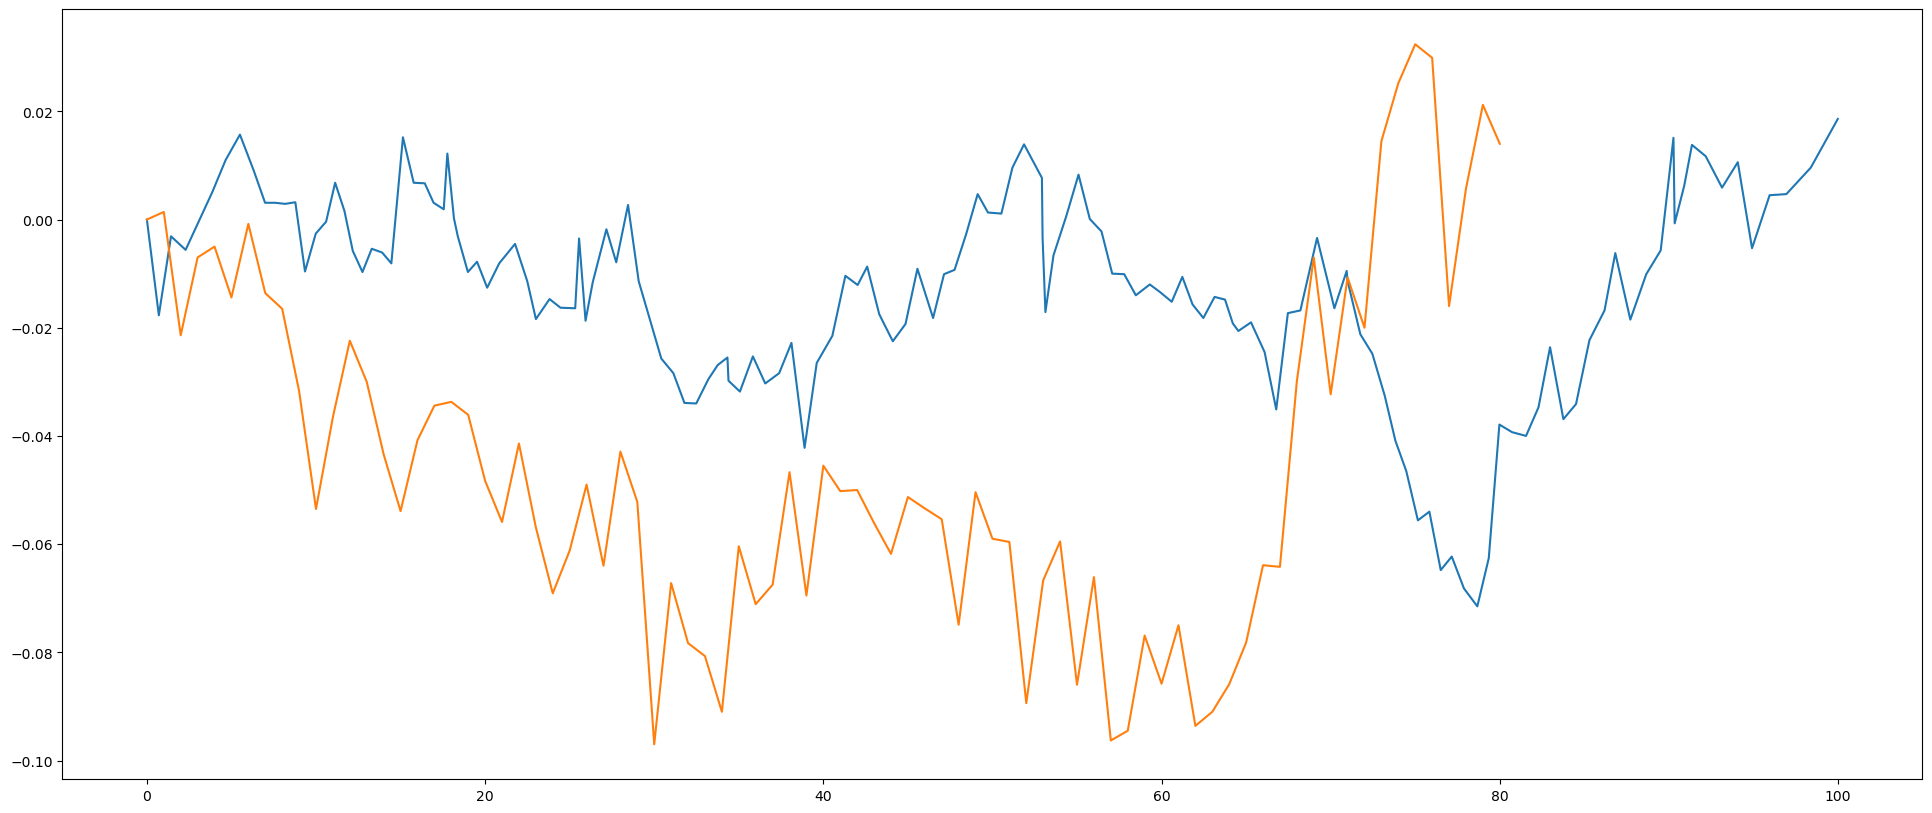

In [3]:
plt.figure(figsize=(24,10))
plt.plot(road_profile_0['X'], road_profile_0['Z'])
plt.plot(road_profile_1['Z'])

In [4]:
class RoadProfileEstimator(nn.Module):
    def __init__(self, hidden_layers=128):
        super().__init__()
        self.cnt_hidden_layers = hidden_layers
        self.lstm_c0 = nn.LSTMCell(1, self.cnt_hidden_layers)
        self.lstm_c1 = nn.LSTMCell(self.cnt_hidden_layers, self.cnt_hidden_layers)
        self.fc = nn.Linear(self.cnt_hidden_layers, 1)
        
    def forward(self, x, look=0):
        outputs = []
        h_t0 = torch.zeros(x.size(0), self.cnt_hidden_layers, dtype=torch.float32)
        c_t0 = torch.zeros(x.size(0), self.cnt_hidden_layers,dtype=torch.float32)
        h_t1 = torch.zeros(x.size(0), self.cnt_hidden_layers,dtype=torch.float32)
        c_t1 = torch.zeros(x.size(0), self.cnt_hidden_layers,dtype=torch.float32)
        for input_step in x.split(1, dim=1):
            h_t0, c_t0 = self.lstm_c0(input_step, (h_t0, c_t0))
            h_t1, c_t1 = self.lstm_c1(h_t0, (h_t1, c_t1))
            output = self.fc(h_t1)
            outputs += [output]
        for i in range(look):
            h_t0, c_t0 = self.lstm_c0(output, (h_t0, c_t0))
            h_t1, c_t1 = self.lstm_c1(h_t0, (h_t1, c_t1))
            output = self.fc(h_t1)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [13]:
model = RoadProfileEstimator(hidden_layers=256)
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.08)

print(road_profile_0['Z'].shape)
print(road_profile_1['Z'].shape)

CNT_EPOCHS = 145
data = np.array([
    road_profile_0['Z'].to_numpy()[:81], 
    road_profile_1['Z'].to_numpy()[:81],
    road_profile_1['Z'].to_numpy()[-81:]
])
x = torch.Tensor(data[:, :-1])
target = torch.Tensor(data[:, 1:])
for i in range(CNT_EPOCHS):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 2.5)
        return loss
    optimizer.step(closure)

(148,)
(81,)
STEP:  0
loss: 0.007367022335529327
loss: 0.007109799887984991


C:\Users\keret\AppData\Local\Temp\ipykernel_56028\3443785968.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 2.5)


loss: 0.006172656547278166
loss: 0.005378198344260454
loss: 0.004705139435827732
loss: 0.0041352370753884315
loss: 0.0036528853233903646
loss: 0.0032447711564600468
loss: 0.0028995568864047527
loss: 0.0026076086796820164
loss: 0.002360743936151266
loss: 0.002152025233954191
loss: 0.001975568477064371
loss: 0.001826395047828555
loss: 0.0017002876847982407
loss: 0.0015936791896820068
loss: 0.0015035526594147086
loss: 0.001427355920895934
loss: 0.0013629330787807703
loss: 0.0013084601378068328
STEP:  1
loss: 0.0012623965740203857
loss: 0.0012234400492161512
loss: 0.0011904905550181866
loss: 0.0011626178165897727
loss: 0.0011390360305085778
loss: 0.0011190816294401884
loss: 0.0011021929094567895
loss: 0.0010878965258598328
loss: 0.001075791078619659
loss: 0.0010655383812263608
loss: 0.0010568517027422786
loss: 0.0010494895977899432
loss: 0.0010432472918182611
loss: 0.0010379519080743194
loss: 0.0010334572289139032
loss: 0.0010296400869265199
loss: 0.0010263954754918814
loss: 0.001023635384

In [6]:
with torch.no_grad():
    future = 100
    pred = model(torch.Tensor(data[1, :-1]).unsqueeze(0), look=future)
    y = pred.detach().numpy()

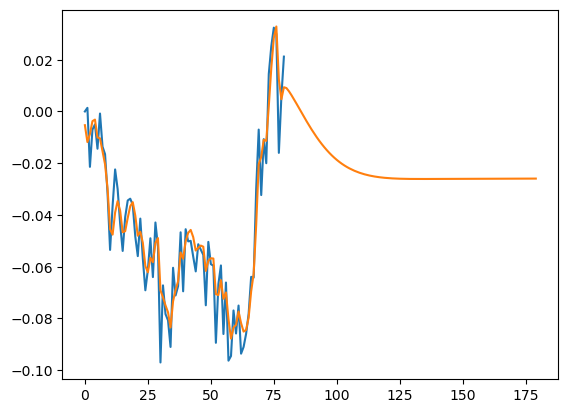

In [7]:
plt.plot(data[1, :-1], )
plt.plot(y.T)

In [8]:
with torch.no_grad():
    future = 100
    pred = model(torch.Tensor(data[1, :10]).unsqueeze(0), look=future)
    y = pred.detach().numpy()

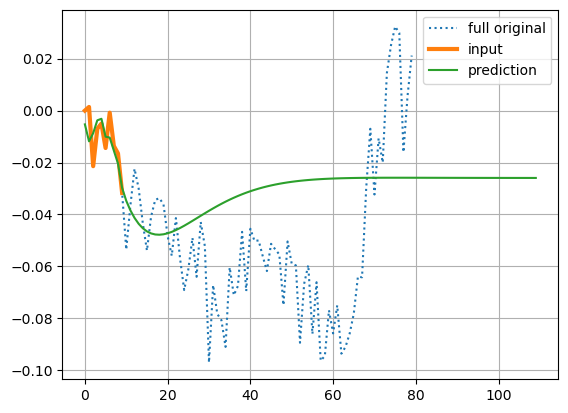

In [9]:
plt.plot(data[1, :-1], linestyle='dotted', label='full original')
plt.plot(data[1, :10], linewidth=3, label='input')
plt.plot(y.T, label='prediction')
plt.legend()
plt.grid()

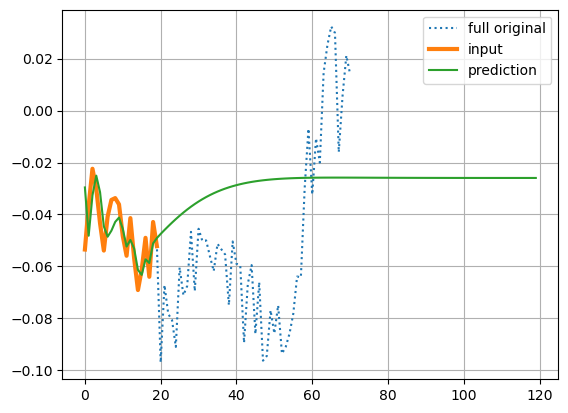

In [10]:
with torch.no_grad():
    future = 100
    pred = model(torch.Tensor(data[1, 10:30]).unsqueeze(0), look=future)
    y = pred.detach().numpy()
plt.plot(data[1, 10:], linestyle='dotted', label='full original')
plt.plot(data[1, 10:30], linewidth=3, label='input')
plt.plot(y.T, label='prediction')
plt.legend()
plt.grid()

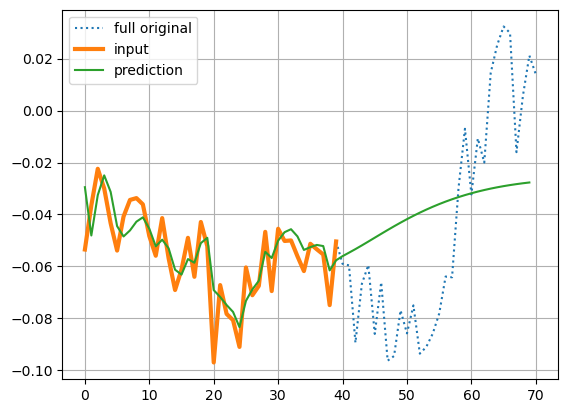

In [11]:
with torch.no_grad():
    future = 30
    pred = model(torch.Tensor(data[2, 10:50]).unsqueeze(0), look=future)
    y = pred.detach().numpy()
noise = np.random.weibull(250, len(y)) - 1.0
y = y.T + noise
plt.plot(data[2, 10:], linestyle='dotted', label='full original')
plt.plot(data[2, 10:50], linewidth=3, label='input')
plt.plot(y, label='prediction')
plt.legend()
plt.grid()

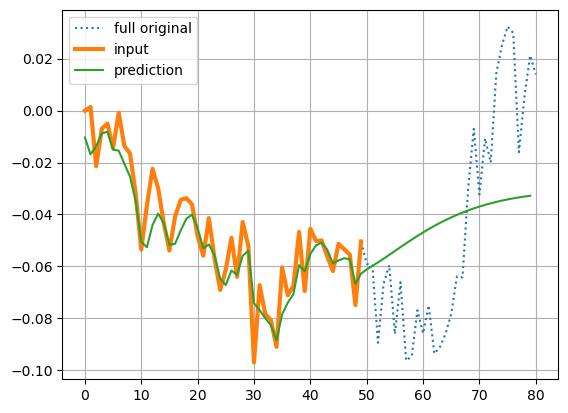

In [12]:
with torch.no_grad():
    future = 30
    pred = model(torch.Tensor(data[2, :50]).unsqueeze(0), look=future)
    y = pred.detach().numpy()
noise = np.random.weibull(250, len(y)) - 1.0
y = y.T + noise
plt.plot(data[2, :], linestyle='dotted', label='full original')
plt.plot(data[2, :50], linewidth=3, label='input')
plt.plot(y, label='prediction')
plt.legend()
plt.grid()